In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

In [ ]:
class Node():
    """
        Class for defining each node of the Decision Tree.
    """
    def __init__(self, attr = None, pred = None, class_label = None) -> None:
        self.attr = attr
        self.children = None
        self.isLeaf = False
        self.pred = pred 
        self.class_label = class_label

In [ ]:
class DecisionTreeClassifierID3():
    """
        Class for implementing Decision Tree Classifier using ID3 (Iterative Dichotomiser 3) Algorithm.
    """
    def __init__(self):
        self.root = None

    def isBalanced(self, df):
        """
            Used to check if all tuples belong to a single class
            : param y: array, label or true values
            : return: boolean, True if all tuples belong to a single class, False otherwise.
        """
        return len(list(df.value_counts())) == 1

    def getEntropy(self, total, df):
        """
            Used to calculate entropy for a particular class value of a column
            : param total: int, total number of row/tuples/training examples
            : param df: array, column
            : return: int
        """
        labels = sorted(df.value_counts().to_dict().items())
        entropy = 0
        for label in labels:
            f = (label[1] / total)
            entropy -= f * np.log(f)
        return entropy

    def gain(self, column, y):
        """
            Used to calculate gain for a column
            : param column: array, column
            : param y: array, label or true values
            : return: int, gain for the column
        """
        total = len(column)
        labels = sorted(y.value_counts().to_dict().items())
        fp = (labels[0][1] / total)
        fn = (labels[1][1] / total)
        total_entropy = - (fp * np.log(fp)) - (fn * np.log(fn))
        g = total_entropy
        concat_df = pd.concat([column, y], axis=1)
        df_dict = {g: d['label']
                   for g, d in concat_df.groupby(by=[concat_df.columns[0]])}
        for key, value in df_dict.items():
            g -= (len(value) / total) * self.getEntropy(key, total, value)
        return g

    def getMaxGain(self, X, y):
        """
            Used to find the attribute which provides maximum gain. 
            : param X: 2D array, matrix of features, with each row being a data entry
            : param y: array, label or true values
            : return: tuple, tuple of attribute name/column name and entropy value
        """
        cols = X.columns
        gain_dict = {}
        for col in cols:
            a = X[col]
            gain_dict[col] = self.gain(a, y)

        return sorted(gain_dict.items(), key=lambda x: x[1], reverse=True)[0]

    def buildTree(self, X, y, attr_classes, class_val=None):
        """
            Used to build the decision tree.
            : param X: 2D array, matrix of features, with each row being a data entry
            : param y: array, label or true values
            : param attr_classes: dict, dictionary of list of distinct classes for each column
            : param class_val: string, distinct class, classification is based on
            : return: Node, a node for the tree
        """
        root = Node()
        if self.isBalanced(y):
            root.isLeaf = True
            root.pred = y.iloc[0]
        elif X is None:
            root.isLeaf = True
            root.pred = y.mode()
        else:
            maxGain = self.getMaxGain(X, y)
            maxGainCol = maxGain[0]
            pred = y.mode()[0]
            attr_list = attr_classes[maxGainCol].copy()
            concat_df = pd.concat([X, y], axis=1)
            df_dict = {g: d for g, d in concat_df.groupby(by=[maxGainCol])}
            root.attr = maxGainCol
            root.children = []
            for key, value in df_dict.items():
                attr_list.remove(key)
                new_X = value.drop(maxGainCol, axis=1).iloc[:, :-1]
                new_y = value.iloc[:, -1]
                root.children.append(self.buildTree(
                    new_X, new_y, attr_classes, key))
            if len(attr_list) > 0:
                root.pred = pred
        root.class_label = class_val
        return root

    def printTree(self, root, num_spaces=0):
        """
            Used to print the decision tree.
            : param root: Node, node of the decision tree
            : param num_spaces: int, number of spaces to be printed
            : return: None
        """
        print("\t" * num_spaces, end="")
        print(root.class_label, "->", end=" ")
        if root.children is None:
            print(root.pred)
        else:
            print(root.attr)
            for child in root.children:
                self.printTree(child, num_spaces + 1)

    def train(self, X, y):
        """
            Used to train the Decision Tree Classifier
            : param X: 2D array, matrix of features, with each row being a data entry
            : param y: array, label or true values
            : return: None
        """
        attr_classes = {}
        cols = X.columns
        for col in cols:
            attr_classes[col] = list(X[col].value_counts().keys())

        self.root = self.buildTree(X, y, attr_classes)

    def predict_one_example(self, X, root):
        """
            Used to predict the value of y for a single example.
            : param X: tuple, one single data entry
            : param root: Node, node of the decision tree
            : return: array, predicted values
        """
        if root.isLeaf:
            return root.pred
        col = root.attr
        val = X[col]
        next_root = [x for x in root.children if x.class_label == val]
        if len(next_root) == 0:
            return root.pred
        return self.predict_one_example(X, next_root[0])

    def predict(self, X):
        """
            Used to predict the value of y
            : param X: 2D array, matrix of features, with each row being a data entry
            : return: array, predicted values
        """
        pred_y = []
        for i in range(len(X)):
            pred_y.append(self.predict_one_example(
                X.iloc[i, :], self.root))

        return pred_y

In [ ]:
df = pd.read_csv("/content/Raw_data.csv")
df

,sequence,label
0,ATCCGTTTCCGGGT,binding site
1,GGCTTTTCGGGCTA,binding site
2,CCCTGCTCTGCCTG,binding site
3,CGCTCCCCGGCGGC,binding site
4,GGGCGGGGCCTGGG,binding site
...,...,...
2395,GAAAAGATTTAGGG,non-binding site
2396,AGGCAGGAGAATCA,non-binding site
2397,TCGTTTATTTATTT,non-binding site
2398,TTTATAATCATTTA,non-binding site


### Splitting data into training and test sets

In [ ]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(df, df['label']):
    train_X = df.loc[train_index].drop('label', axis = 1)['sequence'].apply(lambda x: pd.Series(list(x)))
    test_X = df.loc[test_index].drop('label', axis = 1)['sequence'].apply(lambda x: pd.Series(list(x)))

    train_y = df.loc[train_index, 'label']
    test_y = df.loc[test_index, 'label']

### Building/Training the Decision Tree Model and printing the generated tree

In [ ]:
clf = DecisionTreeClassifierID3()
clf.train(train_X, train_y)

clf.printTree(clf.root)

None -> 7
	A -> 0
		A -> 12
			A -> 2
				A -> non-binding site
				C -> 6
					A -> binding site
					C -> non-binding site
					G -> binding site
					T -> non-binding site
				G -> 13
					A -> binding site
					G -> non-binding site
					T -> non-binding site
				T -> non-binding site
			C -> non-binding site
			G -> 9
				A -> 11
					A -> non-binding site
					C -> binding site
					G -> non-binding site
					T -> non-binding site
				C -> non-binding site
				G -> 3
					A -> binding site
					C -> 2
						C -> binding site
						T -> non-binding site
					G -> binding site
					T -> binding site
				T -> 1
					G -> binding site
					T -> non-binding site
			T -> 9
				A -> non-binding site
				C -> 13
					A -> non-binding site
					C -> binding site
					G -> binding site
				G -> 4
					A -> binding site
					C -> non-binding site
					G -> non-binding site
					T -> non-binding site
				T -> non-binding site
		C -> 10
			A -> 1
				A -> 13
					A -> non-binding site
					C 

### Make predictions on the test set

In [ ]:
pred_y = clf.predict(test_X)

### Display the confusion matrix for the model

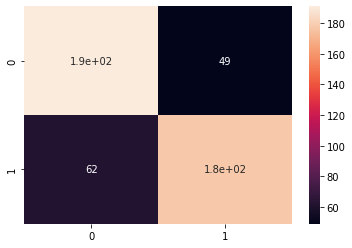

In [ ]:
cf_matrix = confusion_matrix(test_y, pred_y)
sns.heatmap(cf_matrix, annot=True)

### Printing the accuracy of our model

In [ ]:
print(np.sum(pred_y == test_y)/len(test_y) * 100, "% accuracy")

76.875 % accuracy


### Using scikit learn to train a decision tree classifier and printing the accuracy 

In [ ]:
sk_clf = DecisionTreeClassifier(random_state=0)

le = LabelEncoder()
yle = LabelEncoder()

train_x = train_X.apply(le.fit_transform)
test_x = test_X.apply(le.transform)
train_Y = yle.fit_transform(train_y)
test_Y = yle.transform(test_y)

sk_clf.fit(train_x, train_Y)
sk_pred = sk_clf.predict(test_x)

print(np.sum(sk_pred == test_Y)/len(test_y) * 100, "% accuracy")

77.29166666666667 % accuracy


### Displaying the confusion matrix for sklearn's model

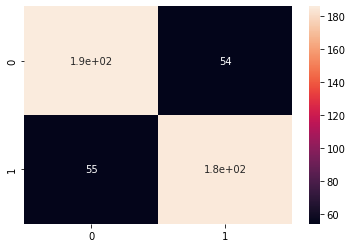

In [ ]:
cf_matrix = confusion_matrix(test_Y, sk_pred)
sns.heatmap(cf_matrix, annot=True)

### Plot the tree generated by sklearn library


[Text(0.6616544676531712, 0.9722222222222222, 'X[7] <= 2.5\ngini = 0.5\nsamples = 1920\nvalue = [959, 961]'),
 Text(0.40904438789254927, 0.9166666666666666, 'X[7] <= 0.5\ngini = 0.49\nsamples = 1503\nvalue = [856, 647]'),
 Text(0.17778729217980296, 0.8611111111111112, 'X[8] <= 2.5\ngini = 0.459\nsamples = 400\nvalue = [143, 257]'),
 Text(0.1265105449507389, 0.8055555555555556, 'X[8] <= 1.5\ngini = 0.483\nsamples = 338\nvalue = [138, 200]'),
 Text(0.08522552339901478, 0.75, 'X[4] <= 2.5\ngini = 0.404\nsamples = 196\nvalue = [55, 141]'),
 Text(0.04729833743842365, 0.6944444444444444, 'X[4] <= 0.5\ngini = 0.443\nsamples = 160\nvalue = [53, 107]'),
 Text(0.024630541871921183, 0.6388888888888888, 'X[13] <= 2.5\ngini = 0.292\nsamples = 62\nvalue = [11, 51]'),
 Text(0.022167487684729065, 0.5833333333333334, 'X[0] <= 2.5\ngini = 0.353\nsamples = 48\nvalue = [11, 37]'),
 Text(0.019704433497536946, 0.5277777777777778, 'X[9] <= 1.5\ngini = 0.418\nsamples = 37\nvalue = [11, 26]'),
 Text(0.00738916

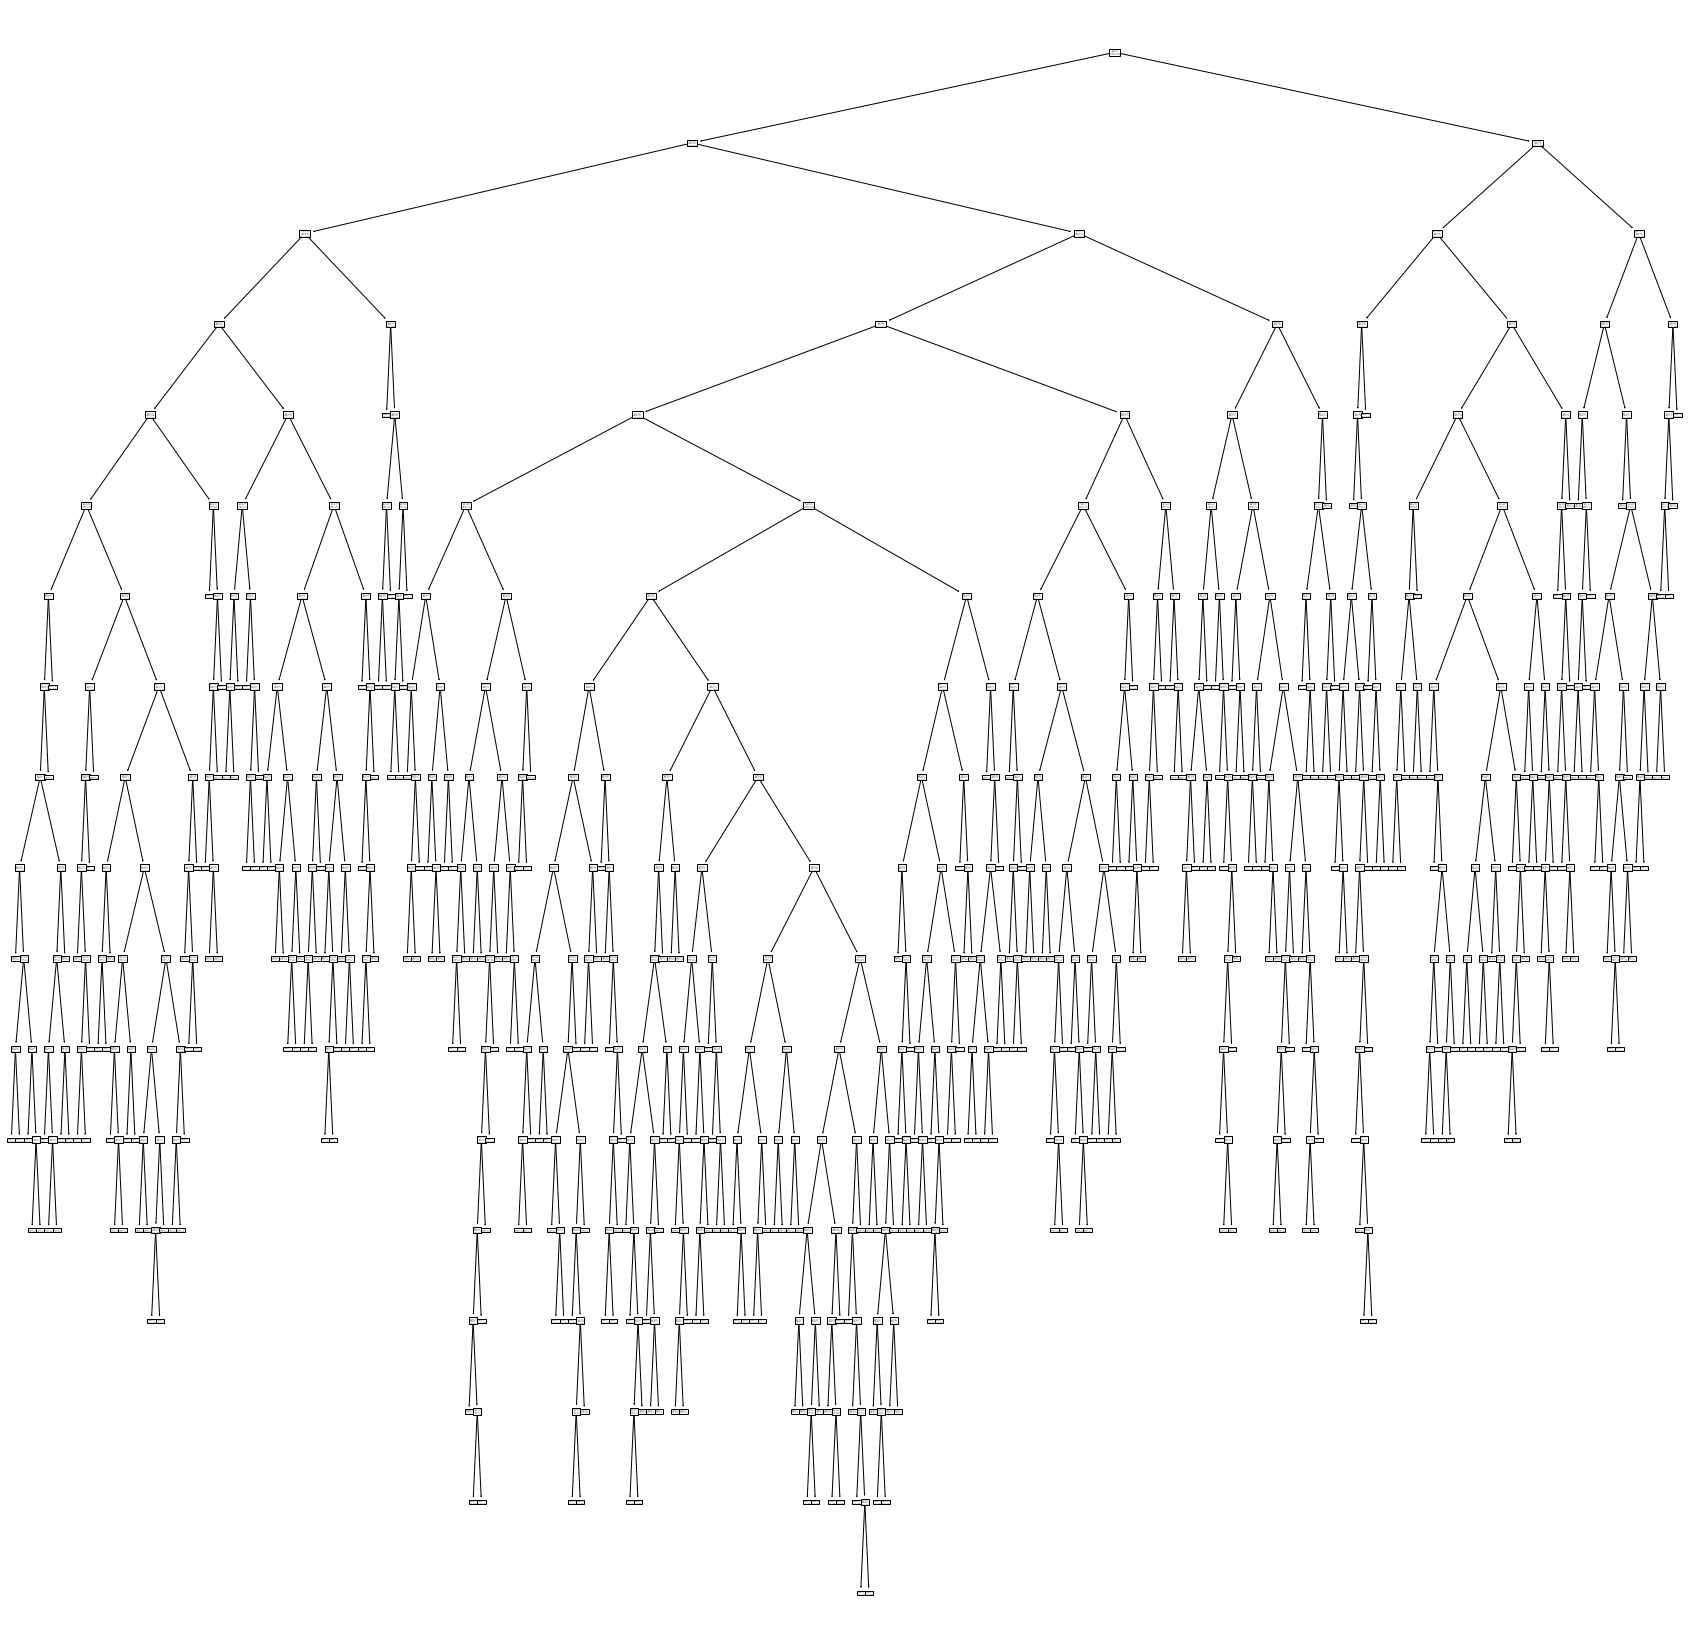

In [ ]:
_, ax = plt.subplots(figsize=(30,30))
plot_tree(sk_clf, ax = ax)